In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from matplotlib.ticker import FuncFormatter
from sklearn.covariance import EllipticEnvelope
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import regularizers
from sklearn.model_selection import GridSearchCV
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras import models  
from keras.layers import Dense
from keras_visualizer import visualizer 
import matplotlib.image as mpimg
import keras.backend as K
import tensorflow as tf

# Import data

In [2]:
data = pd.read_csv('data.csv')
data = data.drop(columns=['id'])
data = data.drop(columns=['zipcode'])
data['date'] = data['date'].str.replace('T000000', '')
data.loc[data['yr_renovated'] == 0,'yr_renovated'] = data[data['yr_renovated'] == 0]['yr_built']
dataTS=data.copy()
dataTS['date'] = pd.to_datetime(dataTS['date'], format='%Y%m%d')
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955,47.5112,-122.257,1340,5650
1,20141209,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,20150225,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,1933,47.7379,-122.233,2720,8062
3,20141209,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,1965,47.5208,-122.393,1360,5000
4,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1987,47.6168,-122.045,1800,7503


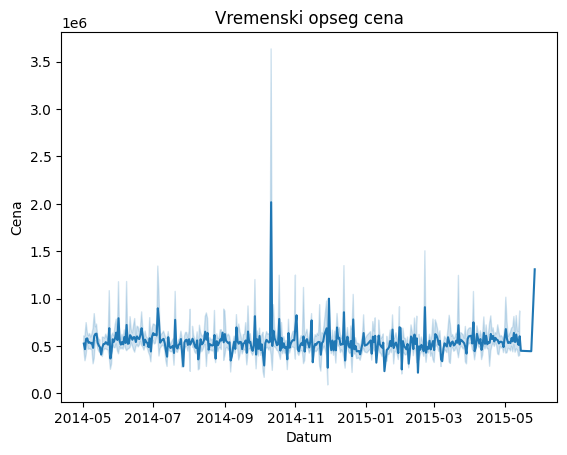

In [3]:
sn.lineplot(x=dataTS['date'], y=dataTS['price'])
plt.xlabel('Datum')
plt.ylabel('Cena')
plt.title('Vremenski opseg cena')
plt.show()

## Data info

- id - Unique ID for each home sold
- date - Date of the home sale
- price - Price of each home sold
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living - Square footage of the apartments interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors
- waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
- view - An index from 0 to 4 of how good the view of the property was
- condition - An index from 1 to 5 on the condition of the apartment,
- grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average - level of construction and design, and 11-13 have a high quality level of construction and design.
- sqft_above - The square footage of the interior housing space that is above ground level
- sqft_basement - The square footage of the interior housing space that is below ground level
- yr_built - The year the house was initially built
- yr_renovated - The year of the house’s last renovation
- zipcode - What zipcode area the house is in
- lat - Lattitude
- long - Longitude
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

# Data visualisation 

In [4]:
# Uklanjanje redova sa nedostajućim vrednostima (NaN)
data = data.dropna()

# Uklanjanje duplikata iz skupa podataka
data = data.drop_duplicates()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21613 non-null  object 
 1   price          21613 non-null  float64
 2   bedrooms       21613 non-null  int64  
 3   bathrooms      21613 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  int64  
 8   view           21613 non-null  int64  
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  sqft_living15  21613 non-null  int64  
 18  sqft_l

In [6]:
sn.set_palette("BuGn_r")

In [7]:
def price_formatter(x, pos):
    return f'${int(x):,}'

C:\Users\jovan\AppData\Local\Temp\ipykernel_32340\3208639644.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sn.histplot(data['price'], kde=True, bins=50, palette=palette)


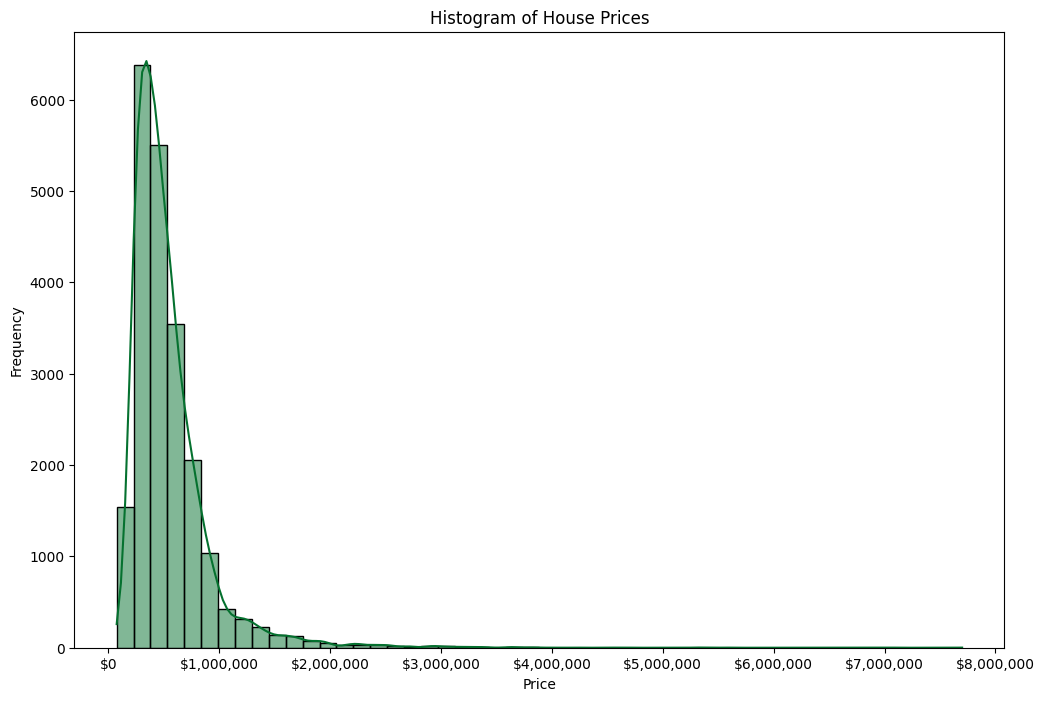

In [8]:
plt.figure(figsize=(12, 8))

palette = sn.color_palette("BuGn_r", as_cmap=True)
sn.histplot(data['price'], kde=True, bins=50, palette=palette)
plt.title('Histogram of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(FuncFormatter(price_formatter))

plt.show()

Sa grafa iznad mozemo primetiti da je najveci broj kuca u cenovnom rangu od 200000 do 1000000

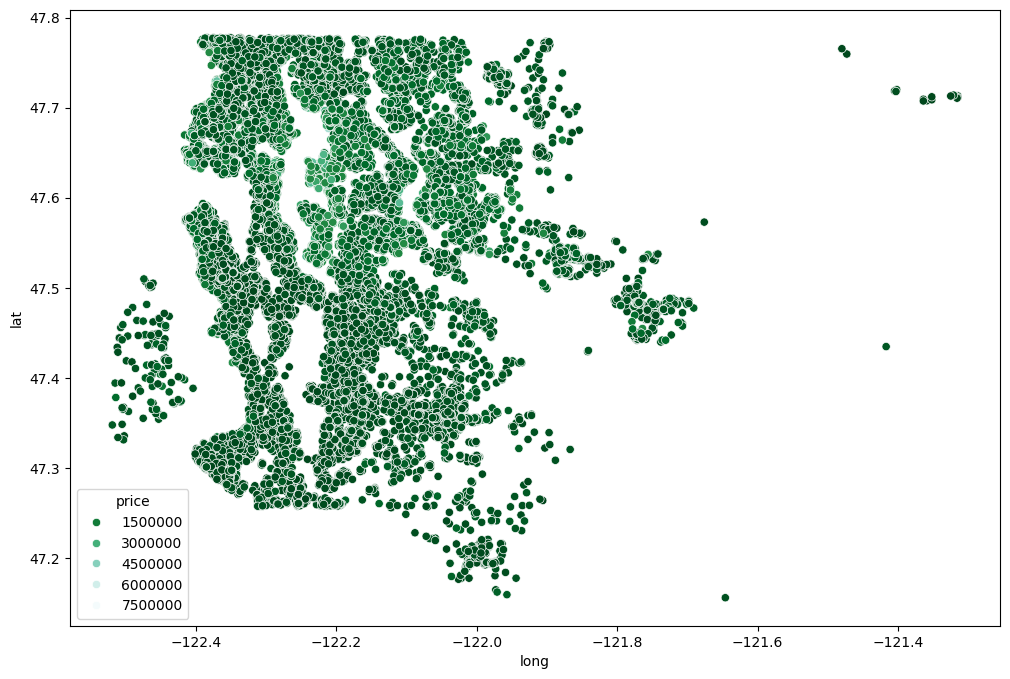

In [9]:
plt.figure(figsize=(12, 8))
sn.scatterplot(x='long', y='lat', data=data, hue='price', palette='BuGn_r') 
plt.show()


Vizuelizacija cena kuca u odnosu na njihovu gografsku lokaciju

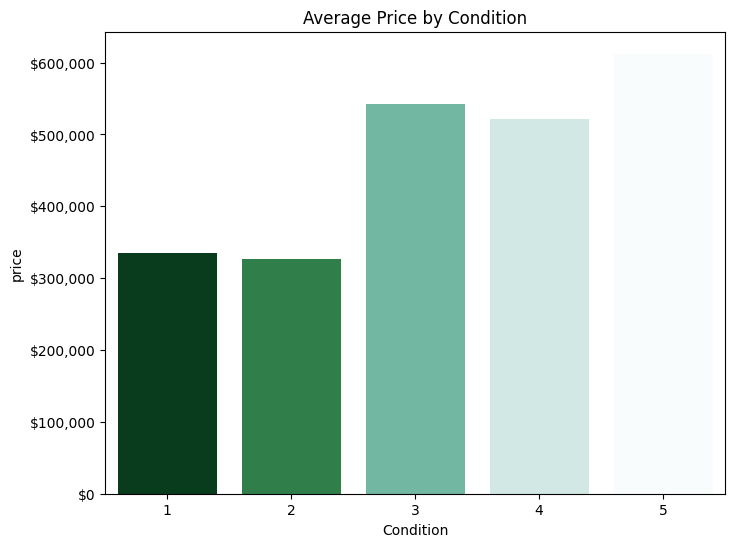

In [10]:
groups = data.groupby(['condition'])['price'].mean()

plt.figure(figsize=(8, 6))
sn.barplot(x=groups.index, y=groups, palette="BuGn_r", hue=groups.index)

plt.gca().yaxis.set_major_formatter(FuncFormatter(price_formatter))

plt.xlabel('Condition')
plt.title('Average Price by Condition')
plt.legend().set_visible(False)
plt.show()

Vizuelizacija prikazuje prosečne cene kuća u zavisnosti od stanja kuce (1-5)

C:\Users\jovan\AppData\Local\Temp\ipykernel_32340\2711215325.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x=groups.index, y=groups, palette="BuGn_r", dodge=False)


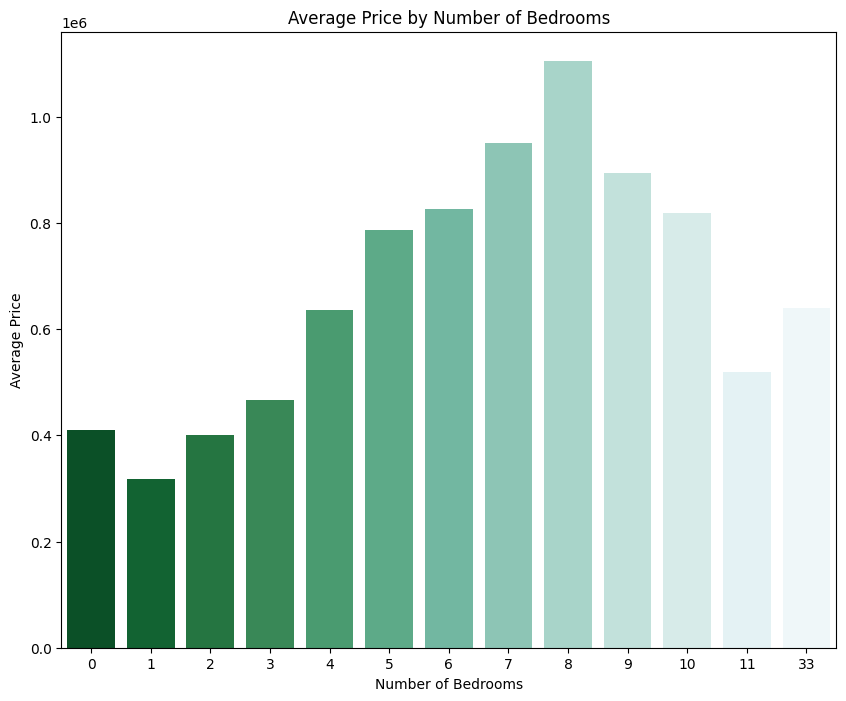

In [11]:
groups = data.groupby(['bedrooms'])['price'].mean()
plt.figure(figsize=(10, 8))
sn.barplot(x=groups.index, y=groups, palette="BuGn_r", dodge=False)

plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Price')
plt.title('Average Price by Number of Bedrooms')
plt.show()

Vizualizacija prikazuje prosečne cene kuća u zavisnosti od broja spavaćih soba.

C:\Users\jovan\AppData\Local\Temp\ipykernel_32340\880240737.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x=groups.index, y=groups, palette="BuGn_r", dodge=False, legend=False)


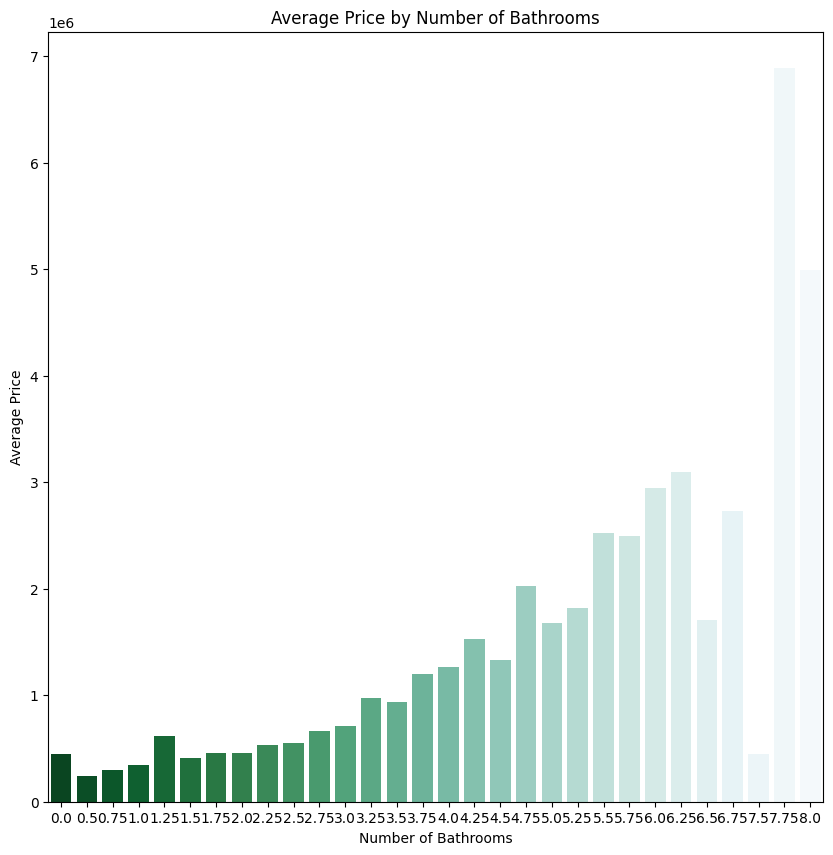

In [12]:
groups = data.groupby(['bathrooms'])['price'].mean()

plt.figure(figsize=(10, 10))
sn.barplot(x=groups.index, y=groups, palette="BuGn_r", dodge=False, legend=False)

plt.xlabel('Number of Bathrooms')
plt.ylabel('Average Price')
plt.title('Average Price by Number of Bathrooms')
plt.show()


Vizualizacija prikazuje prosečne cene kuća u zavisnosti od broja kupatila.

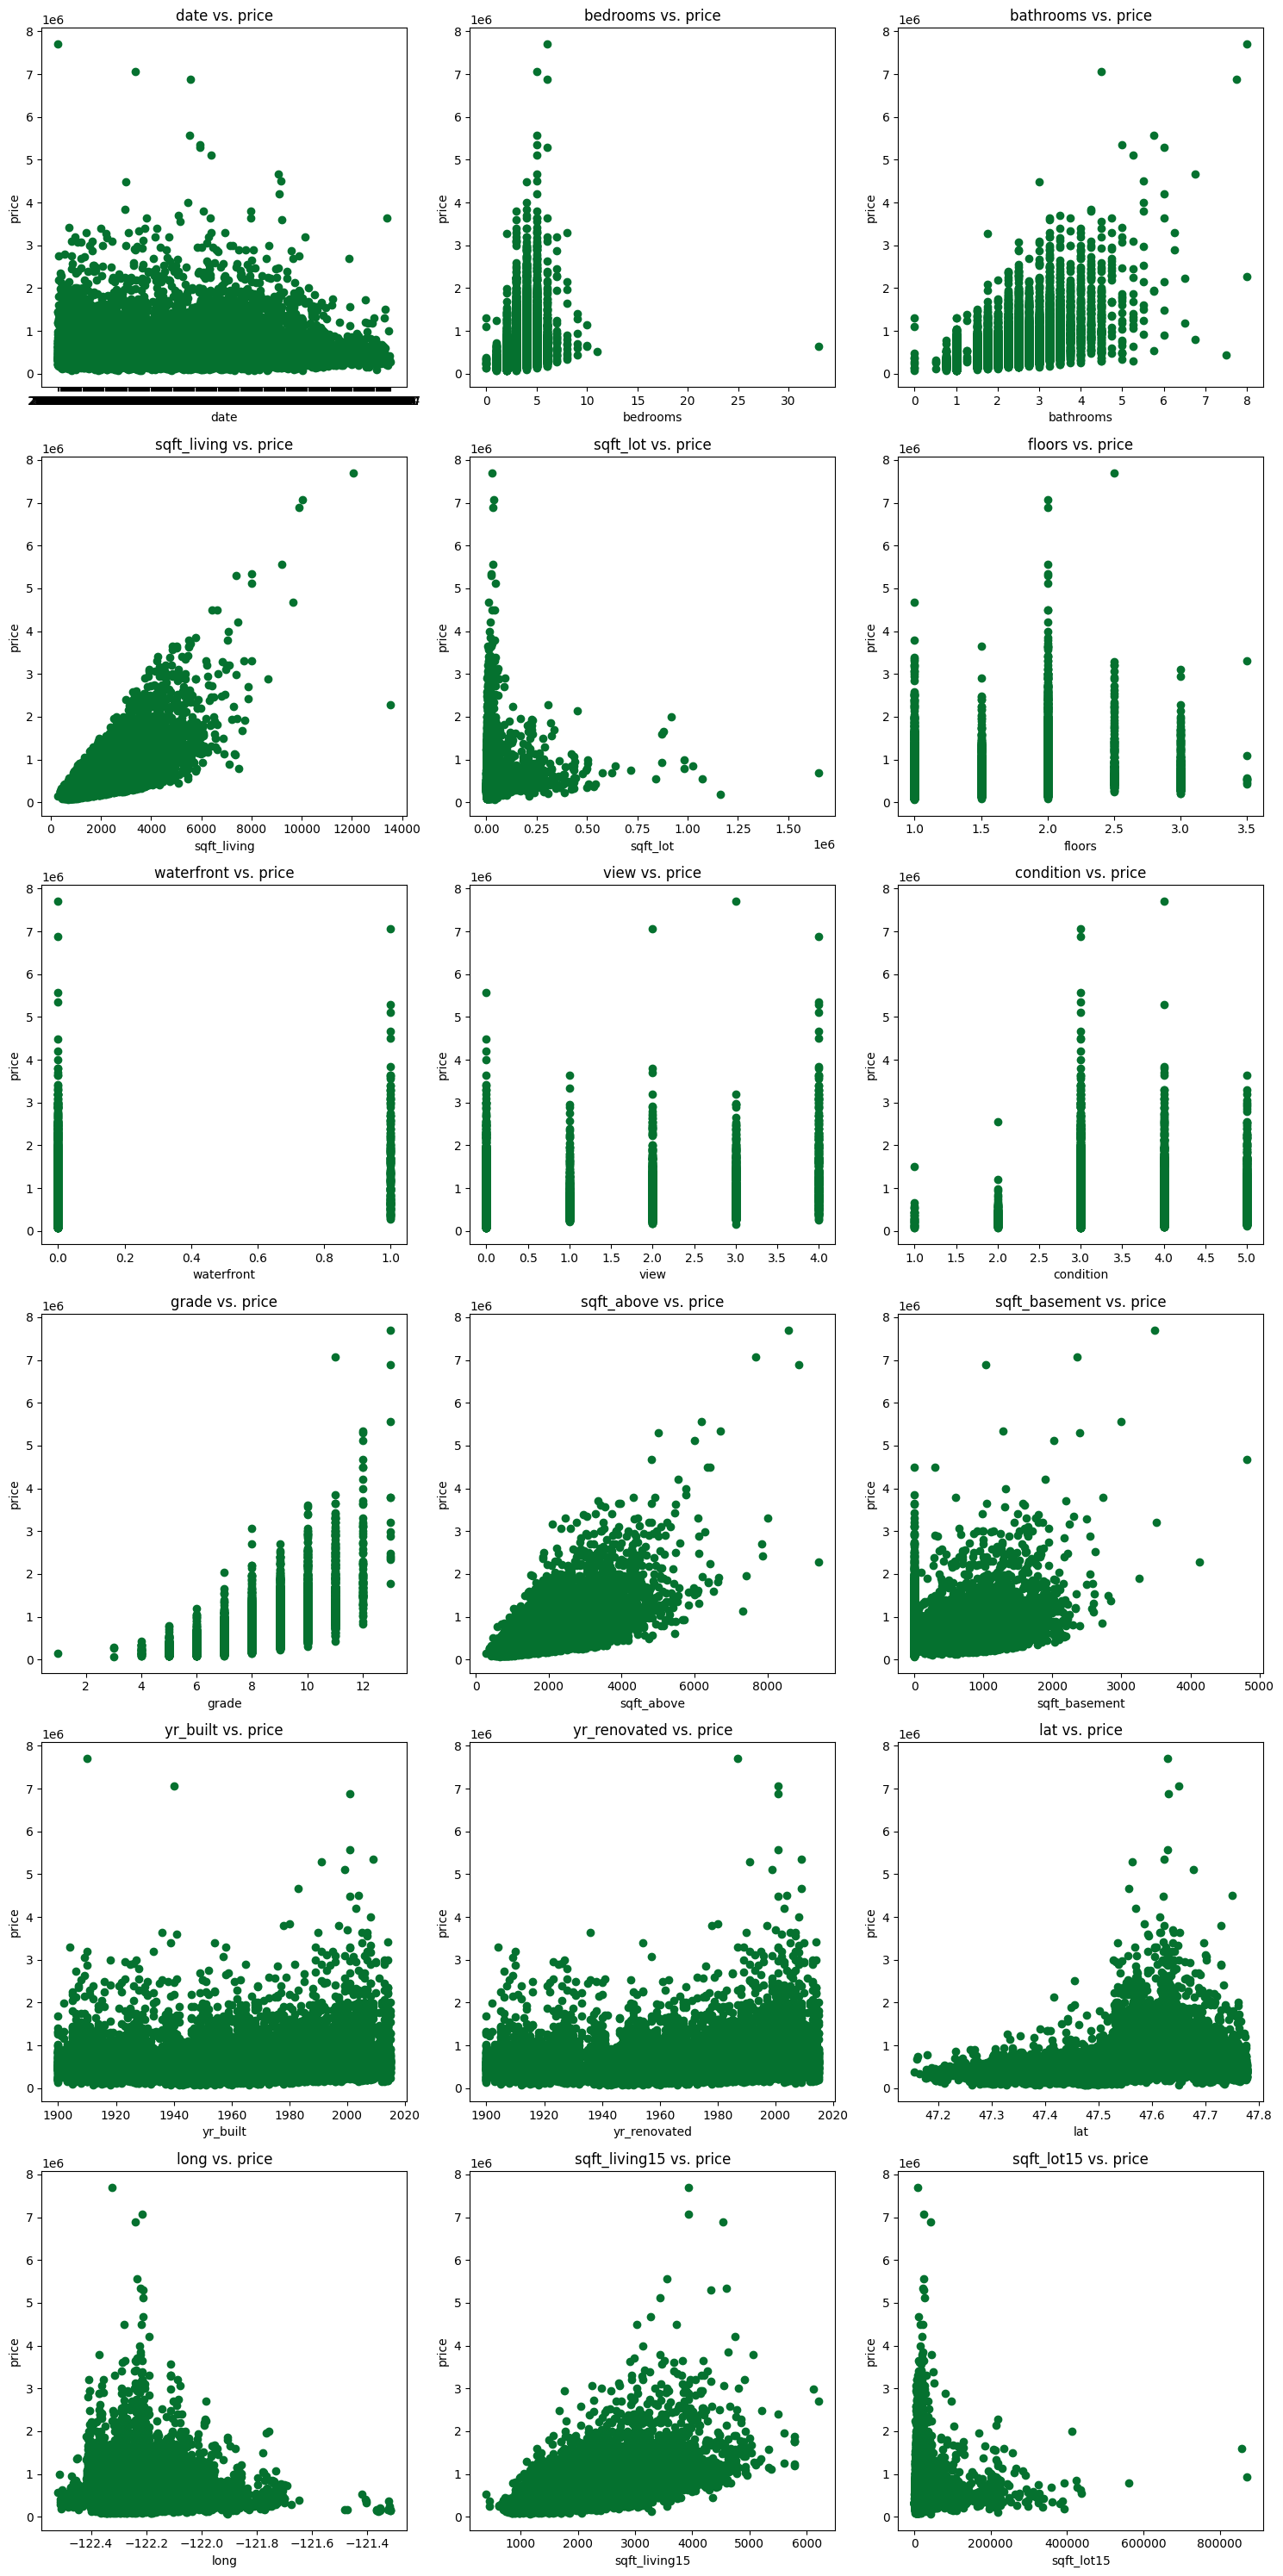

In [13]:
num_columns_per_row = 3
columns_to_plot = [c for c in data.columns if c != 'price']

num_rows = len(columns_to_plot) // num_columns_per_row
if len(columns_to_plot) % num_columns_per_row != 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, num_columns_per_row, figsize=(15, 5 * num_rows))

for i, c in enumerate(columns_to_plot):
    row_index = i // num_columns_per_row
    col_index = i % num_columns_per_row
    axes[row_index, col_index].scatter(data[c], data['price'])
    axes[row_index, col_index].set_title(f'{c} vs. price')
    axes[row_index, col_index].set_xlabel(c)
    axes[row_index, col_index].set_ylabel('price')

plt.tight_layout()
plt.show()

# Removing outliers

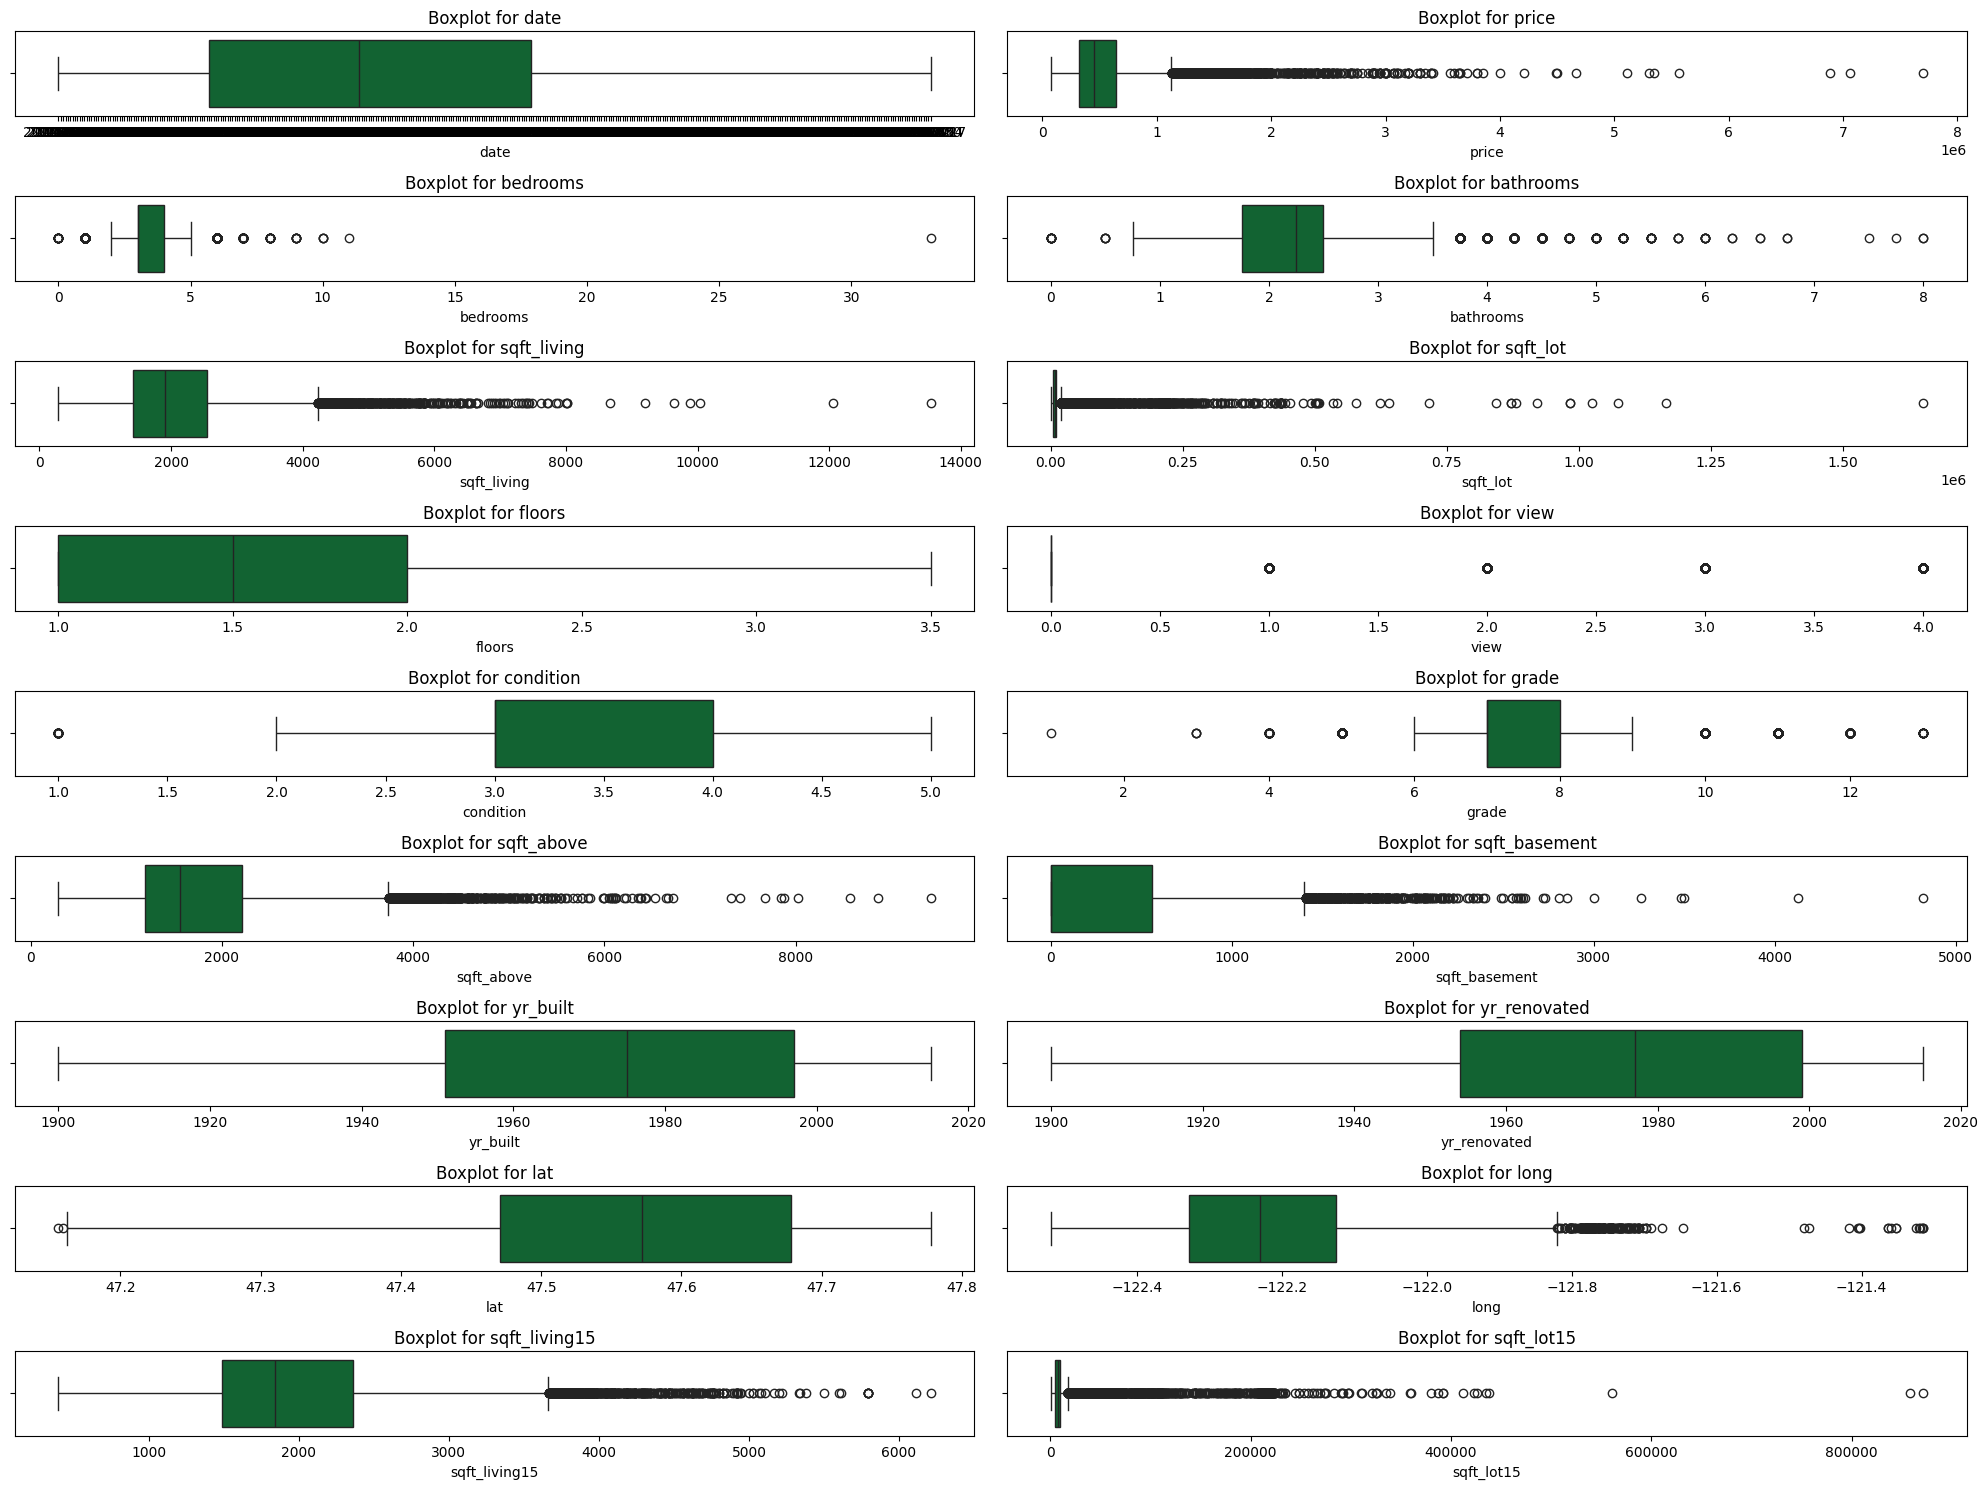

In [14]:
attributes = ['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

plt.figure(figsize=(20, 15))
num_rows = (len(attributes) - 1) // 2 + 1
num_columns = min(2, len(attributes))

for i, attribute in enumerate(attributes, 1):
    plt.subplot(num_rows, num_columns, i)
    sn.boxplot(x=data[attribute])
    plt.title(f'Boxplot for {attribute}')

plt.tight_layout()
plt.show()

In [15]:
selected_data = data[attributes]
outlier_detector = EllipticEnvelope(contamination=.05)
outlier_detector.fit(selected_data)
outliers = outlier_detector.predict(selected_data)
print('Removing', (outliers == -1).sum(), 'outliers')
data = data[outliers != -1]
data.shape

f:\Program Files (x86)\Python\Lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (73.389255780681680 > 66.621968460274474). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
f:\Program Files (x86)\Python\Lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (69.761998633847114 > 22.227643288589583). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
f:\Program Files (x86)\Python\Lib\site-packages\sklearn\covariance\_robust_covariance.py:184: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (68.618592140819700 > 7.253863410243333). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(

Removing 1081 outliers


(20532, 19)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20532 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20532 non-null  object 
 1   price          20532 non-null  float64
 2   bedrooms       20532 non-null  int64  
 3   bathrooms      20532 non-null  float64
 4   sqft_living    20532 non-null  int64  
 5   sqft_lot       20532 non-null  int64  
 6   floors         20532 non-null  float64
 7   waterfront     20532 non-null  int64  
 8   view           20532 non-null  int64  
 9   condition      20532 non-null  int64  
 10  grade          20532 non-null  int64  
 11  sqft_above     20532 non-null  int64  
 12  sqft_basement  20532 non-null  int64  
 13  yr_built       20532 non-null  int64  
 14  yr_renovated   20532 non-null  int64  
 15  lat            20532 non-null  float64
 16  long           20532 non-null  float64
 17  sqft_living15  20532 non-null  int64  
 18  sqft_lot15 

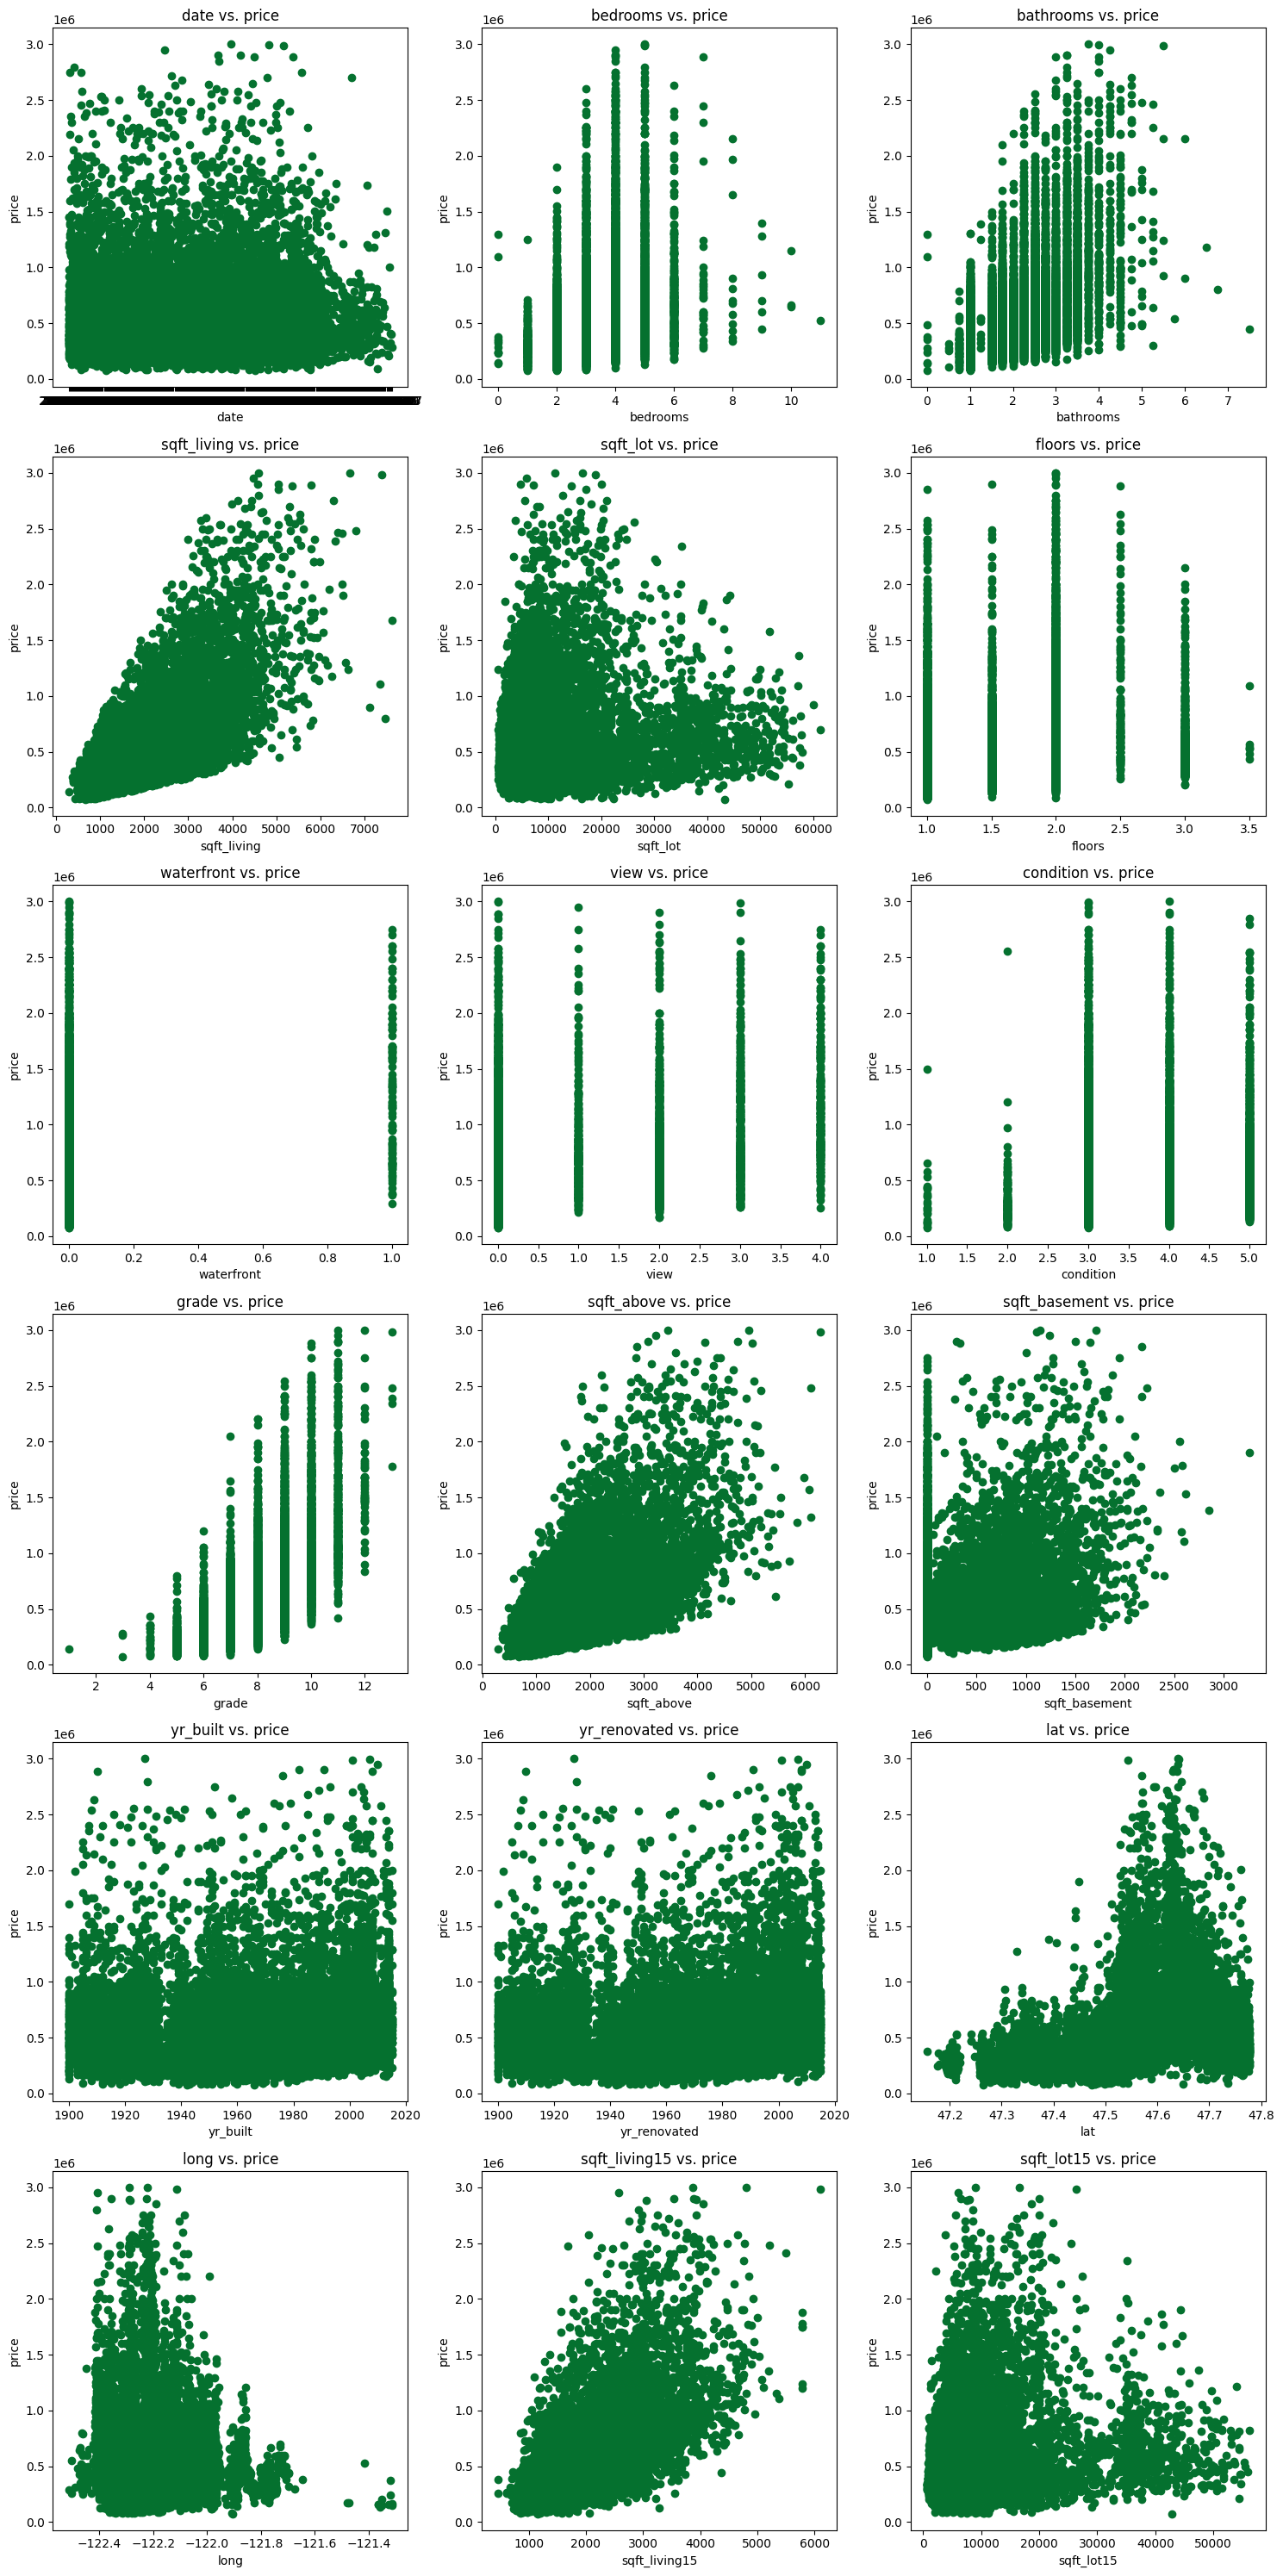

In [17]:
num_columns_per_row = 3
columns_to_plot = [c for c in data.columns if c != 'price']

num_rows = len(columns_to_plot) // num_columns_per_row
if len(columns_to_plot) % num_columns_per_row != 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, num_columns_per_row, figsize=(15, 5 * num_rows))

for i, c in enumerate(columns_to_plot):
    row_index = i // num_columns_per_row
    col_index = i % num_columns_per_row
    axes[row_index, col_index].scatter(data[c], data['price'])
    axes[row_index, col_index].set_title(f'{c} vs. price')
    axes[row_index, col_index].set_xlabel(c)
    axes[row_index, col_index].set_ylabel('price')

plt.tight_layout()
plt.show()

<Axes: >

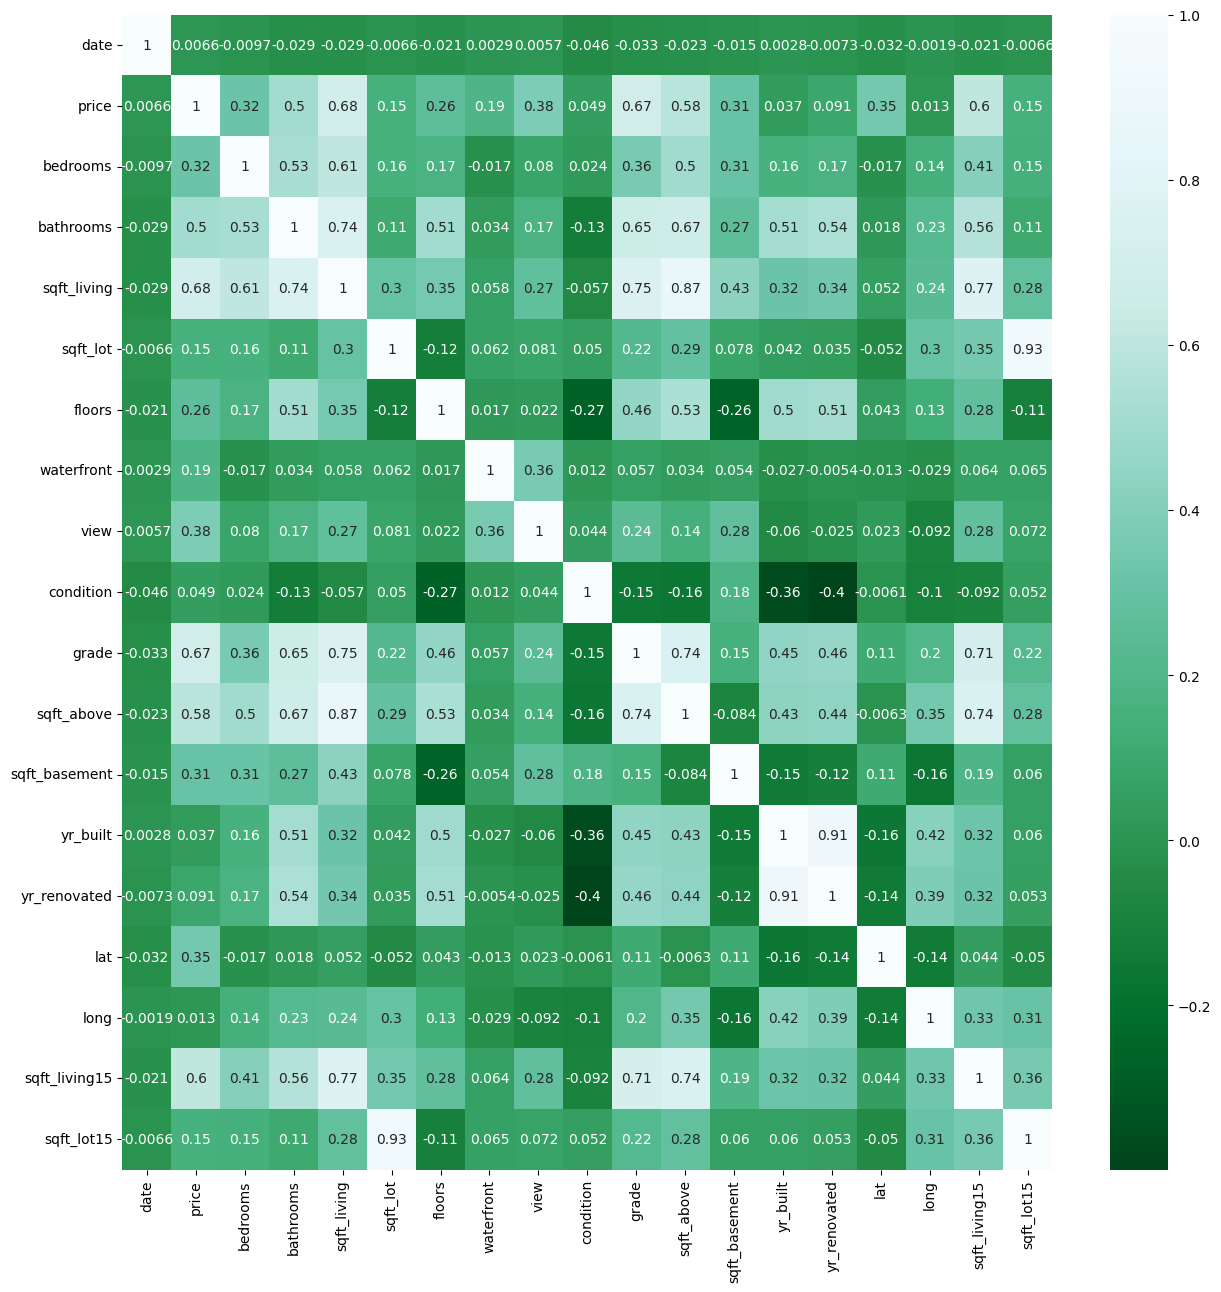

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
sn.heatmap(data.corr(),annot=True, cmap="BuGn_r", ax=ax)

In [19]:
data = data.drop(columns=['sqft_above','yr_renovated', 'sqft_lot15'])

<Axes: >

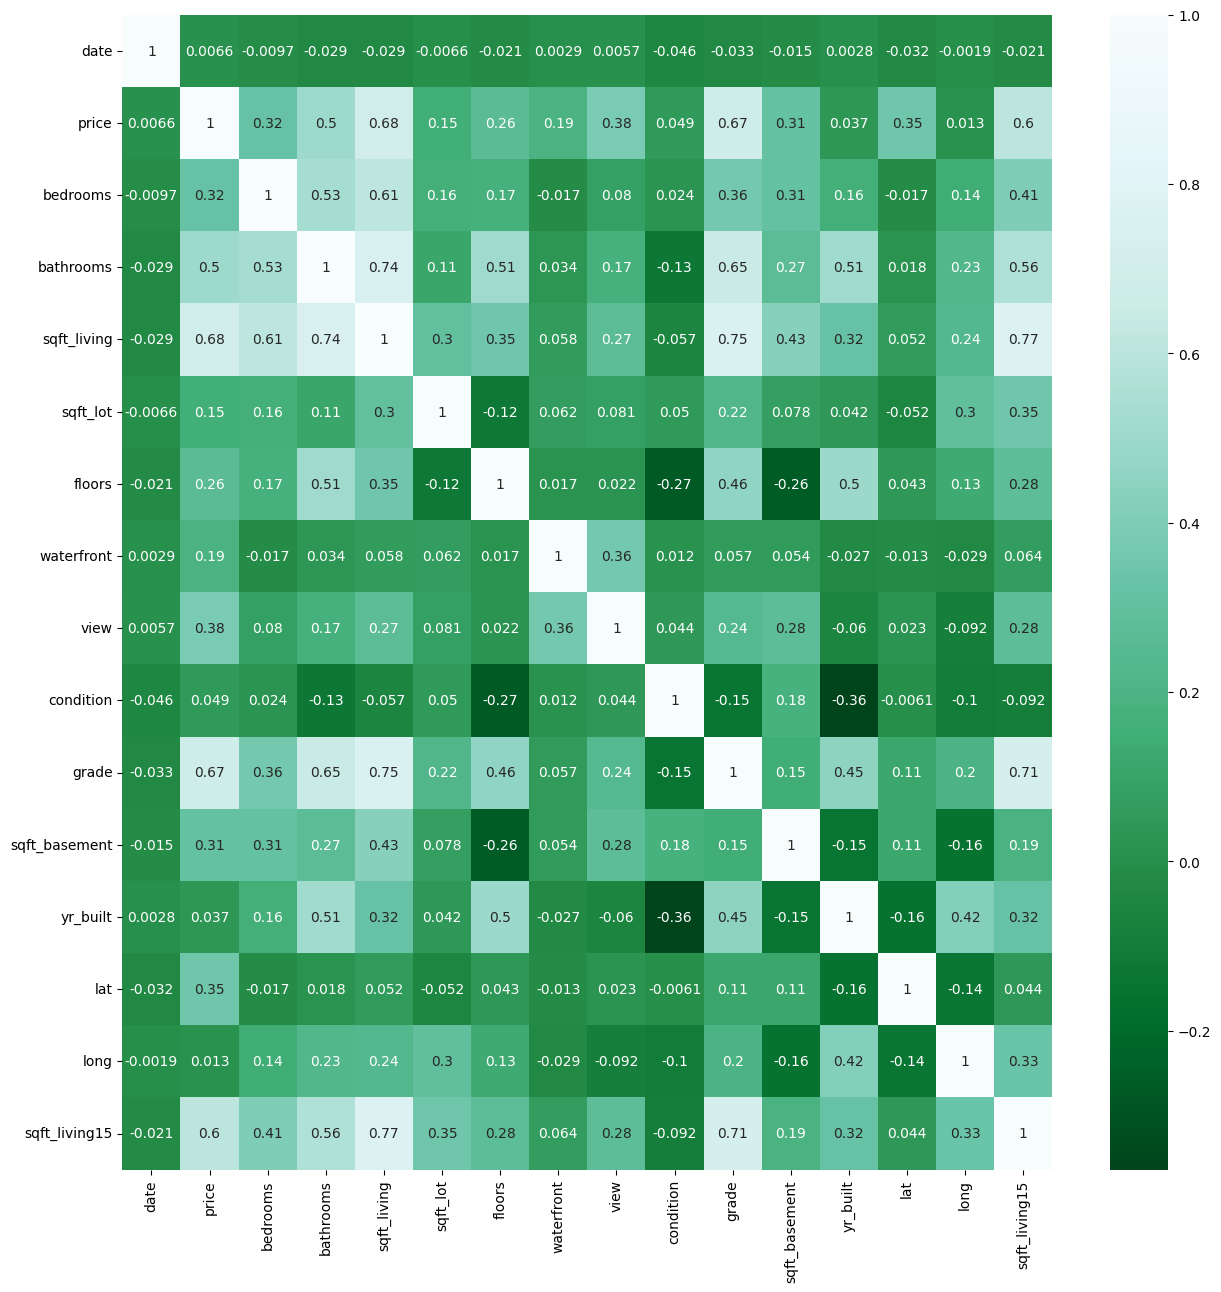

In [20]:
fig, ax = plt.subplots(figsize=(15,15))
sn.heatmap(data.corr(),annot=True, cmap="BuGn_r", ax=ax)

# Normalize data

In [21]:
scaler = preprocessing.StandardScaler()
data_std = scaler.fit_transform(data)

In [22]:
data_pd = pd.DataFrame(data_std)
data_pd.columns = data.columns
data_pd

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,lat,long,sqft_living15
0,-0.653991,-0.950249,-0.403285,-1.463593,-1.001630,-0.449501,-0.910472,-0.073726,-0.29615,-0.632410,-0.550852,-0.668072,-0.529007,-0.374795,-0.267212,-0.928179
1,-0.609865,0.037270,-0.403285,0.204544,0.620212,-0.237685,0.935466,-0.073726,-0.29615,-0.632410,-0.550852,0.260033,-0.664215,1.155962,-0.724527,-0.405266
2,1.419908,-1.081147,-1.507614,-1.463593,-1.480015,0.129269,-0.910472,-0.073726,-0.29615,-0.632410,-1.433212,-0.668072,-1.272650,1.279269,-0.090187,1.133590
3,-0.609865,0.243459,0.701043,1.205426,-0.091531,-0.535984,-0.910472,-0.073726,-0.29615,2.444156,-0.550852,1.443368,-0.190988,-0.304751,-1.270355,-0.898298
4,1.418332,-0.050204,-0.403285,-0.129083,-0.418233,-0.126188,-0.910472,-0.073726,-0.29615,-0.632410,0.331508,-0.668072,0.552655,0.395691,1.296510,-0.240923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20527,-0.764755,-0.518815,-0.403285,0.538172,-0.593252,-1.050758,2.781403,-0.073726,-0.29615,-0.632410,0.331508,-0.668072,1.296297,0.997633,-0.923680,-0.644312
20528,1.419458,-0.393852,0.701043,0.538172,0.316846,-0.427814,0.935466,-0.073726,-0.29615,-0.632410,0.331508,-0.668072,1.465307,-0.378443,-1.041697,-0.196101
20529,-0.741792,-0.387288,-1.507614,-1.797220,-1.188317,-1.021620,0.935466,-0.073726,-0.29615,-0.632410,-0.550852,-0.668072,1.296297,0.232255,-0.577006,-1.406270
20530,1.395369,-0.393852,-0.403285,0.538172,-0.511577,-0.883513,0.935466,-0.073726,-0.29615,-0.632410,0.331508,-0.668072,1.127288,-0.204792,1.119485,-0.823596


# Split data

In [23]:
X = data_pd.drop(columns=['price'])
y = data_pd['price']

In [24]:
# 10% podataka za testiranje, 90% za treniranje modela
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [25]:
X_test

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,lat,long,sqft_living15
6017,1.415631,-1.507614,-1.463593,-1.433343,-0.382976,-0.910472,-0.073726,-0.29615,-0.632410,-0.550852,-0.668072,-0.698017,1.213602,-0.879424,-1.316628
4584,-0.678755,1.805372,-0.129083,0.818567,-0.106230,0.012497,-0.073726,-0.29615,-0.632410,-0.550852,0.561667,-0.292394,1.259569,-0.562254,0.252109
17689,1.398521,2.909700,1.205426,0.515201,0.092015,0.935466,-0.073726,-0.29615,-0.632410,0.331508,-0.668072,0.045626,0.365776,0.558905,0.775021
4269,1.482720,-1.507614,-1.463593,-1.188317,0.022829,-0.910472,-0.073726,-0.29615,-0.632410,-0.550852,-0.668072,0.248437,-0.849782,3.332299,-0.659252
5192,1.459531,-0.403285,-0.462711,-0.394898,-0.065783,-0.910472,-0.073726,-0.29615,0.905873,-0.550852,-0.668072,-0.596611,0.474491,0.116342,0.207288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,-0.628551,0.701043,2.206309,2.020364,-0.669035,1.858434,-0.073726,-0.29615,2.444156,1.213868,1.373760,-1.847283,0.387665,-0.488494,1.253113
16860,-0.746294,-1.507614,-1.463593,-1.281660,-0.486090,-0.910472,-0.073726,-0.29615,0.905873,-2.315571,-0.668072,-0.630413,-1.035836,-0.761407,-1.137344
6792,-0.697216,-0.403285,-1.463593,-1.398340,-0.442849,-0.910472,-0.073726,-0.29615,0.905873,-2.315571,-0.668072,-0.867027,-1.224080,1.421903,-0.793716
14643,-0.767907,-1.507614,-1.463593,-1.316664,1.725879,-0.910472,-0.073726,-0.29615,-0.632410,-1.433212,-0.668072,-0.495205,-2.078473,-0.230332,-0.949095


In [26]:
y_test

6017    -0.706571
4584    -0.370421
17689    0.434027
4269    -0.696887
5192     1.433730
           ...   
3733     3.027006
16860   -0.912447
6792    -1.081147
14643   -1.331073
5154    -0.706259
Name: price, Length: 2054, dtype: float64

# Neural network GRID search

In [27]:
# Funkcija za kreiranje neuronske mreže sa prilagodljivim parametrima
def create_network(optimizer, neuron_number, layer_number, activation, loss):
    network = models.Sequential()
    # Dodavanje ulaznog sloja sa određenim brojem neurona i aktivacionom funkcijom
    network.add(layers.Dense(units=neuron_number, activation=activation, input_shape=(15,)))
    
    # Dodavanje dodatnih gustih slojeva prema zadatom broju slojeva
    for i in range(layer_number):
        network.add(layers.Dense(units=neuron_number, activation=activation))
    
    # Dodavanje izlaznog sloja sa jednim neuronu
    network.add(layers.Dense(units=1))
    network.compile(loss=loss, optimizer=optimizer)
    return network

In [28]:
neural_network = KerasRegressor(build_fn=create_network, verbose=0)

C:\Users\jovan\AppData\Local\Temp\ipykernel_32340\766838004.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neural_network = KerasRegressor(build_fn=create_network, verbose=0)


In [29]:
# različitih vrednosti za hiperparametre koje cemo ispitati
epochs = [1]
batches = [64, 128, 256]
optimizers = ["rmsprop", "adam", "sgd"]
neuron_numbers = [16, 32]
#layer_numbers = [0, 1, 2]
layer_numbers = [2, 3]
activations = ['relu', 'sigmoid', 'tanh']
losses = ['huber_loss', 'mean_squared_error', 'mean_absolute_error']

In [30]:
# kreiranje recnika koji sadrži sve ove hiperparametre, potrebno je zbog GridSearchCV  
hyperparameters = dict(
    epochs=epochs, 
    batch_size=batches, 
    optimizer=optimizers, 
    neuron_number=neuron_numbers, 
    layer_number=layer_numbers,
    activation=activations,
    loss=losses
)
grid = GridSearchCV(n_jobs=6,estimator=neural_network, param_grid=hyperparameters, verbose=10)

In [31]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [32]:
# najbolje vrednosti za hiperparametre 
params = grid_result.best_params_

params

{'activation': 'relu',
 'batch_size': 64,
 'epochs': 1,
 'layer_number': 3,
 'loss': 'huber_loss',
 'neuron_number': 32,
 'optimizer': 'adam'}

# Neural Network using best-found hyperparameters

In [33]:
# kreiranje neuronske mreže koristeći najbolje pronađene hiperparametre
network = create_network(
    optimizer=params['optimizer'],
    neuron_number=params['neuron_number'],
    layer_number=params['layer_number'],
    activation=params['activation'],
    loss=params['loss']
)

In [34]:
network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                512       
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,713
Trainable params: 3,713
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = network.fit( X_train, y_train, epochs=500, verbose=1,  batch_size=params['batch_size'], validation_data=(X_test, y_test))

Epoch 1/500


289/289 [==============================] - 1s 2ms/step - loss: 0.1376 - val_loss: 0.0979
Epoch 2/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0919 - val_loss: 0.0883
Epoch 3/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0780 - val_loss: 0.0759
Epoch 4/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0691 - val_loss: 0.0675
Epoch 5/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0638 - val_loss: 0.0682
Epoch 6/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0599 - val_loss: 0.0643
Epoch 7/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0575 - val_loss: 0.0668
Epoch 8/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0552 - val_loss: 0.0598
Epoch 9/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0537 - val_loss: 0.0582
Epoch 10/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0522 - val_loss: 0.0594
E

In [36]:
scores = network.evaluate(X_test, y_test, verbose=0)
scores

0.06122373417019844

In [37]:
#Kreiranje dataset za cuvanje rezultata
columns = ['activation', 'loss', 'optimizer', 'layer_number', 'neuron_number', 'score']
result = [[params['activation'],params['loss'], params['optimizer'], params['layer_number'],params['neuron_number'], scores]]
results_df = pd.DataFrame(result, columns=columns)

### Loss history

In [38]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
count = range(1, len(train_loss) + 1)

C:\Users\jovan\AppData\Local\Temp\ipykernel_32340\2475458549.py:3: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Training loss', 'Test loss')


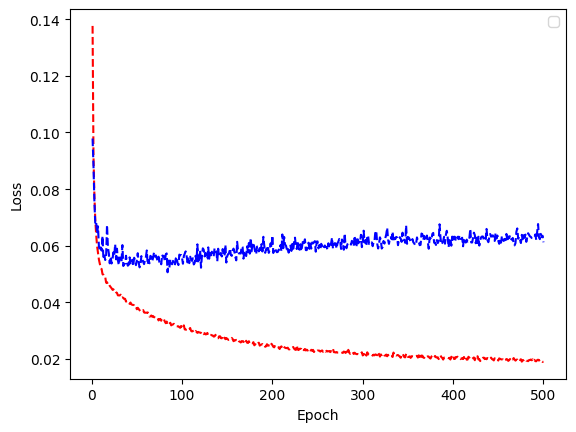

0.06122373044490814


In [39]:
plt.plot(count, train_loss, 'r--')
plt.plot(count, test_loss, 'b--')
plt.legend('Training loss', 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print(test_loss[-1])

## Optimization with Dropout, EarlyStopping and kernel regularization

- Callback EarlyStopping se koristi da zaustavi obuku modela ako validation loss prestane da se smanjuje tokom nekoliko epoha
- Dropout se koristi kao tehnika regularizacije u neuronskim mrežama da bi se smanjio overfitting na trening podatke
- Kernel regularizacija smanjuje overfitting na trening podatke dodavanjem kazne na velike vrednosti težina u mreži

In [40]:
# Funkcija za kreiranje neuronske mreže sa prilagodljivim parametrima
def create_optimized_network(optimizer, neuron_number, layer_number, activation, loss, dropout_rate):
    network = Sequential()
    
    # Dodavanje ulaznog sloja sa određenim brojem neurona i aktivacionom funkcijom
    network.add(Dense(units=neuron_number, activation=activation, input_shape=(15,),
                      kernel_regularizer=regularizers.l2(0.01)))  # Dodajemo L2 regularizaciju
    
    # Dodavanje Dropout sloja
    network.add(Dropout(rate=dropout_rate))
    
    # Dodavanje dodatnih gustih slojeva prema zadatom broju slojeva
    for i in range(layer_number):
        network.add(Dense(units=neuron_number, activation=activation, 
                          kernel_regularizer=regularizers.l2(0.01)))  # Dodajemo L2 regularizaciju
        # Dodavanje Dropout sloja
        network.add(Dropout(rate=dropout_rate))
    
    # Dodavanje izlaznog sloja sa jednim neuronu
    network.add(Dense(units=1))
    
    # Kompajliranje modela
    network.compile(loss=loss, optimizer=optimizer)
    
    return network

In [41]:
# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [42]:
neural_network = KerasRegressor(build_fn=create_optimized_network, verbose=0)

C:\Users\jovan\AppData\Local\Temp\ipykernel_32340\1859646340.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neural_network = KerasRegressor(build_fn=create_optimized_network, verbose=0)


In [43]:
# Različitih vrednosti za hiperparametre koje ćemo ispitati
epochs = [1]
batches = [64, 128, 256]
optimizers = ["rmsprop", "adam"]
neuron_numbers = [16, 32]
layer_numbers = [2, 3]
activations = ['relu', 'sigmoid']
losses = ['huber_loss', 'mean_squared_error', 'mean_absolute_error']
dropout_rates = [0.2, 0.5, 0.8]

In [44]:
hyperparameters = dict(
    epochs=epochs, 
    batch_size=batches, 
    optimizer=optimizers, 
    neuron_number=neuron_numbers, 
    layer_number=layer_numbers,
    activation=activations,
    loss=losses,
    dropout_rate=dropout_rates  
)

In [45]:
grid = GridSearchCV(n_jobs=6, estimator=neural_network, param_grid=hyperparameters, verbose=10)
grid_result = grid.fit(X_train, y_train, callbacks=[early_stopping], validation_data=(X_test, y_test))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


f:\Program Files (x86)\Python\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [46]:
params = grid_result.best_params_

params

{'activation': 'relu',
 'batch_size': 64,
 'dropout_rate': 0.2,
 'epochs': 1,
 'layer_number': 2,
 'loss': 'huber_loss',
 'neuron_number': 32,
 'optimizer': 'rmsprop'}

## Creating a final neural network

In [47]:
# Kreiranje neuronske mreže koristeći najbolje pronađene hiperparametre
network = create_optimized_network(
    optimizer=params['optimizer'],
    neuron_number=params['neuron_number'],
    layer_number=params['layer_number'],
    activation=params['activation'],
    loss=params['loss'],
    dropout_rate=params['dropout_rate']
)

In [48]:
network.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 32)                512       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                

In [49]:
# Trening modela sa dodatim EarlyStopping callback-om
history = network.fit(X_train, y_train, epochs=500, verbose=1, batch_size=params['batch_size'], 
                      validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/500


289/289 [==============================] - 1s 2ms/step - loss: 0.5562 - val_loss: 0.2304
Epoch 2/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1969 - val_loss: 0.1469
Epoch 3/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1550 - val_loss: 0.1278
Epoch 4/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1442 - val_loss: 0.1193
Epoch 5/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1384 - val_loss: 0.1159
Epoch 6/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1367 - val_loss: 0.1137
Epoch 7/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1335 - val_loss: 0.1197
Epoch 8/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1327 - val_loss: 0.1135
Epoch 9/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1313 - val_loss: 0.1097
Epoch 10/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1297 - val_loss: 0.1079
E

In [50]:
# Evaluacija modela
scores = network.evaluate(X_test, y_test, verbose=0)
scores

0.09544304013252258

In [51]:
new_row = pd.DataFrame([[params['activation'], params['loss'], params['optimizer'], params['layer_number'], params['neuron_number'], scores]], columns=columns)
results_df = pd.concat([results_df, new_row], ignore_index=True)

### Loss histotry

In [52]:
train_loss1 = history.history['loss']
test_loss1 = history.history['val_loss']
count1 = range(1, len(train_loss1) + 1)

C:\Users\jovan\AppData\Local\Temp\ipykernel_32340\3588194284.py:3: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Training loss', 'Test loss')


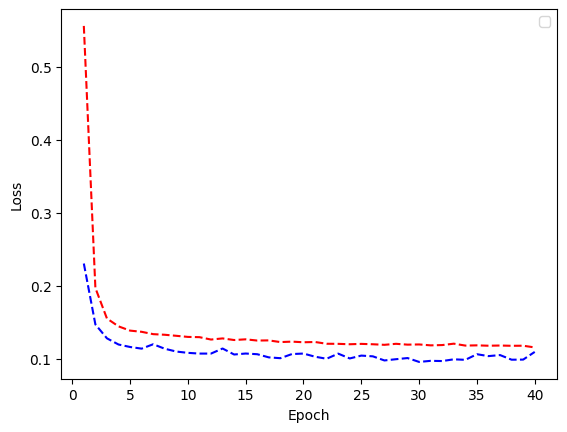

0.10917375981807709


In [53]:
plt.plot(count1, train_loss1, 'r--')
plt.plot(count1, test_loss1, 'b--')
plt.legend('Training loss', 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print(test_loss1[-1])

In [54]:
test_predictions = network.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions, 'Actual': y_test.to_numpy().flatten()})
test_results.reset_index(drop=True, inplace=True)  # Resetovanje indeksa
test_results.head()

65/65 [==============================] - 0s 644us/step


,Train Predictions,Actual
0,-0.589747,-0.706571
1,0.079264,-0.370421
2,0.529584,0.434027
3,-0.777727,-0.696887
4,0.176145,1.433730


In [55]:
network.summary() 
  
visualizer(network, format='png', view=True)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 32)                512       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                

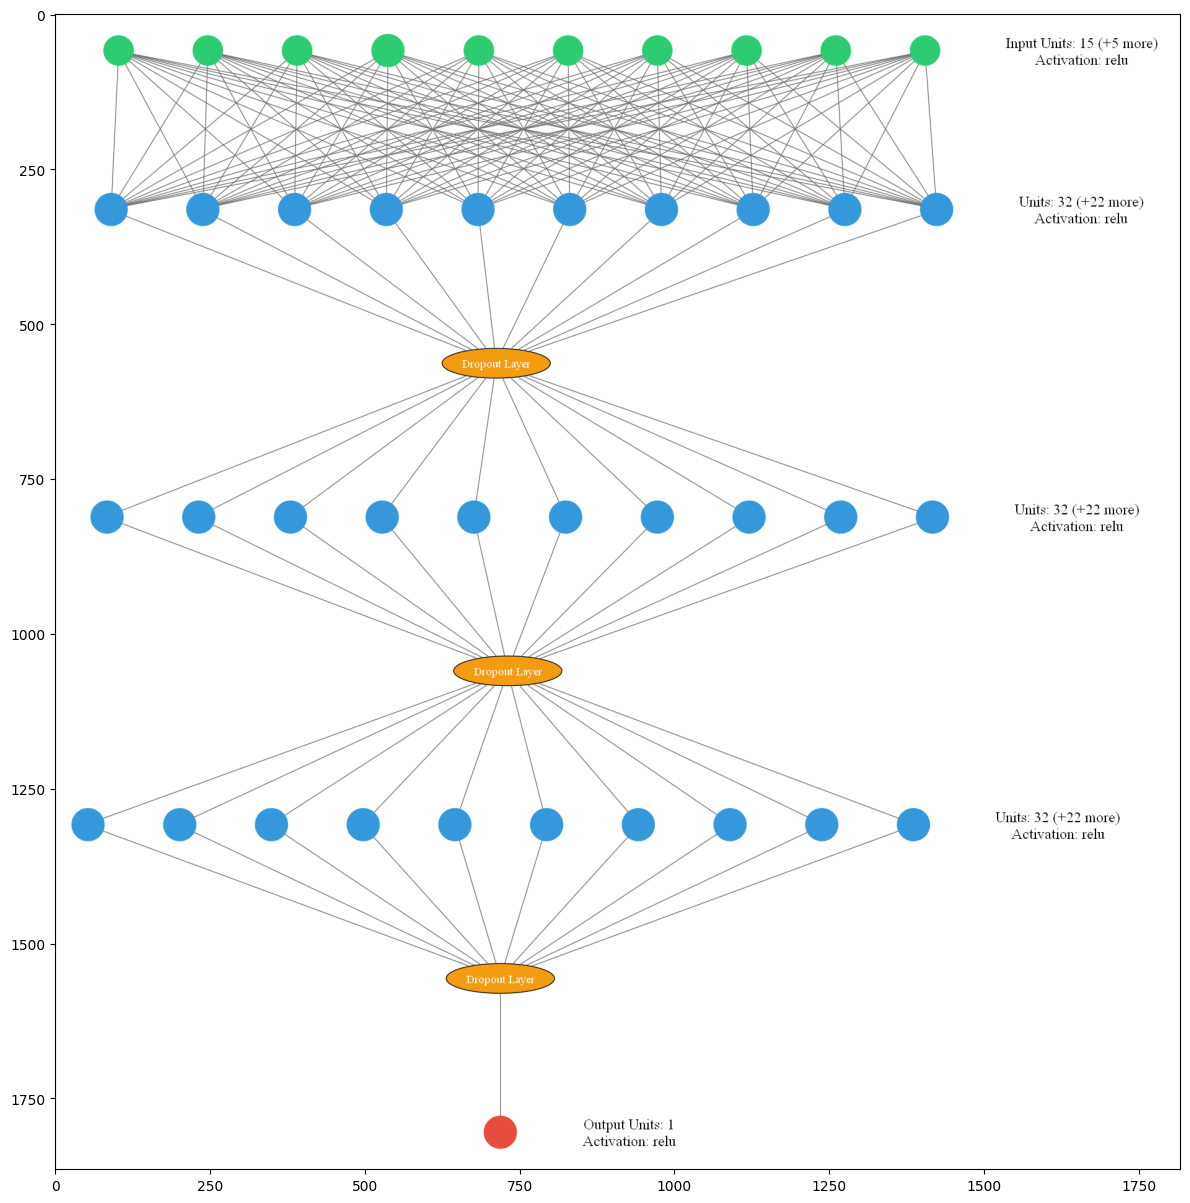

In [56]:
import matplotlib.image as mpimg
plt.figure(figsize = (15,15))
img = mpimg.imread('graph.png')
plt.imshow(img)
plt.show()

## Custom loss functions

In [57]:
def custom_loss1(y_true, y_pred):
    # Mean Squared Error
    mse = K.mean(K.square(y_pred - y_true), axis=-1)

    #Dodatni faktori
    factor1 = 0.5  # Faktor za prvi deo loss funkcije
    factor2 = 0.5  # Faktor za drugi deo loss funkcije

    #Drugi deo loss funkcije: Penalizacija za velike greške
    penalization = K.mean(K.square(K.maximum(0.0, y_true - y_pred)), axis=-1)

    #Ukupni loss
    loss = factor1 * mse + factor2 * penalization

    return loss

Ova custom loss funkcija kombinuje dva ključna aspekta kako bi procenila performanse modela tokom treninga neuronske mreže. Prvo, koristi se srednja kvadratna greška (MSE) kako bi se izračunala prosečna kvadratna razlika između stvarnih i predviđenih vrednosti. Ovo omogućava ocenu preciznosti modela u predviđanju ciljne promenljive. Drugo, uvodi se kazna za velike greške. Ova kazna primenjuje se na greške gde su predviđene vrednosti manje od stvarnih, što se postiže ograničenjem kvadratne razlike na nulu za takve slučajeve.


In [58]:
def custom_loss2(y_true, y_pred):
    # Računanje kvadratne razlike između stvarnih i predviđenih vrednosti
    squared_error = tf.square(y_true - y_pred)
    
    # Izračunavanje važnosti atributa za svaki uzorak
    attribute_importance = tf.abs(y_true - y_pred)
    attribute_importance = tf.reduce_mean(attribute_importance, axis=1)
    attribute_importance = attribute_importance / tf.reduce_max(attribute_importance)
    
    # Množenje kvadratne greške sa važnostima atributa
    weighted_squared_error = squared_error * attribute_importance[:, tf.newaxis]
    
    # Računanje srednje vrednosti težinske kvadratne greške
    loss = tf.reduce_mean(weighted_squared_error)
    
    return loss

Ovaj pristup omogućava modelu da efikasnije nauči na osnovu značajnosti svakog atributa, čime se poboljšavaju performanse predikcije. Funkcija se sastoji iz nekoliko ključnih koraka. Prvo, računa se kvadratna razlika između stvarnih i predviđenih vrednosti, što je osnovni korak u proceni tačnosti modela. Zatim, važnost svakog atributa za svaki uzorak se izračunava merenjem apsolutne razlike između stvarnih i predviđenih vrednosti, a zatim se te važnosti normalizuju kako bi se izračunale u opsegu od 0 do 1. Nakon toga, kvadratna greška se množi sa važnostima atributa za svaki uzorak. Ovaj korak daje veću težinu atributima koji su značajniji za predviđanje, dok manje važni atributi imaju manji uticaj na konačnu grešku. Konačno, računa se srednja vrednost težinske kvadratne greške. Ova vrednost predstavlja ukupnu grešku modela uzimajući u obzir važnost atributa.

In [59]:
K.clear_session()

In [60]:
network1 = create_network(
    optimizer=params['optimizer'],
    neuron_number=params['neuron_number'],
    layer_number=params['layer_number'],
    activation=params['activation'],
    loss=custom_loss1
)

In [61]:
network2 = create_network(
    optimizer=params['optimizer'],
    neuron_number=params['neuron_number'],
    layer_number=params['layer_number'],
    activation=params['activation'],
    loss=custom_loss2
)

In [62]:
history = network1.fit(X_train, y_train, epochs=500, verbose=1, batch_size=params['batch_size'], 
                      validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/500


289/289 [==============================] - 1s 1ms/step - loss: 0.2250 - val_loss: 0.1871
Epoch 2/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1507 - val_loss: 0.1586
Epoch 3/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1274 - val_loss: 0.1380
Epoch 4/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1140 - val_loss: 0.1334
Epoch 5/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1051 - val_loss: 0.1370
Epoch 6/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0999 - val_loss: 0.1423
Epoch 7/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0949 - val_loss: 0.1131
Epoch 8/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0919 - val_loss: 0.1177
Epoch 9/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0895 - val_loss: 0.1078
Epoch 10/500
289/289 [==============================] - 0s 992us/step - loss: 0.0866 - val_loss: 0.1115

In [63]:
history2 = network2.fit(X_train, y_train, epochs=500, verbose=1, batch_size=params['batch_size'], 
                      validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/500


289/289 [==============================] - 2s 2ms/step - loss: 0.2031 - val_loss: 0.1659
Epoch 2/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1363 - val_loss: 0.1517
Epoch 3/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1177 - val_loss: 0.1421
Epoch 4/500
289/289 [==============================] - 0s 1ms/step - loss: 0.1056 - val_loss: 0.1170
Epoch 5/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0970 - val_loss: 0.1097
Epoch 6/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0933 - val_loss: 0.1106
Epoch 7/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0869 - val_loss: 0.1045
Epoch 8/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0848 - val_loss: 0.1286
Epoch 9/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0831 - val_loss: 0.0983
Epoch 10/500
289/289 [==============================] - 0s 1ms/step - loss: 0.0794 - val_loss: 0.0960
E

In [64]:
scores1 = network1.evaluate(X_test, y_test, verbose=0)
scores1

0.0941818580031395

In [65]:
scores2 = network2.evaluate(X_test, y_test, verbose=0)
scores2

0.08834979683160782

In [66]:
new_row1 = pd.DataFrame([[params['activation'], "custom_loss1", params['optimizer'], params['layer_number'], params['neuron_number'], scores1]], columns=columns)
results_df = pd.concat([results_df, new_row1], ignore_index=True)

new_row2 = pd.DataFrame([[params['activation'], "custom_loss2", params['optimizer'], params['layer_number'], params['neuron_number'], scores2]], columns=columns)
results_df = pd.concat([results_df, new_row2], ignore_index=True)

In [67]:
train_loss1 = history.history['loss']
test_loss1 = history.history['val_loss']
count1 = range(1, len(train_loss1) + 1)

train_loss2 = history2.history['loss']
test_loss2 = history2.history['val_loss']
count2 = range(1, len(train_loss2) + 1)

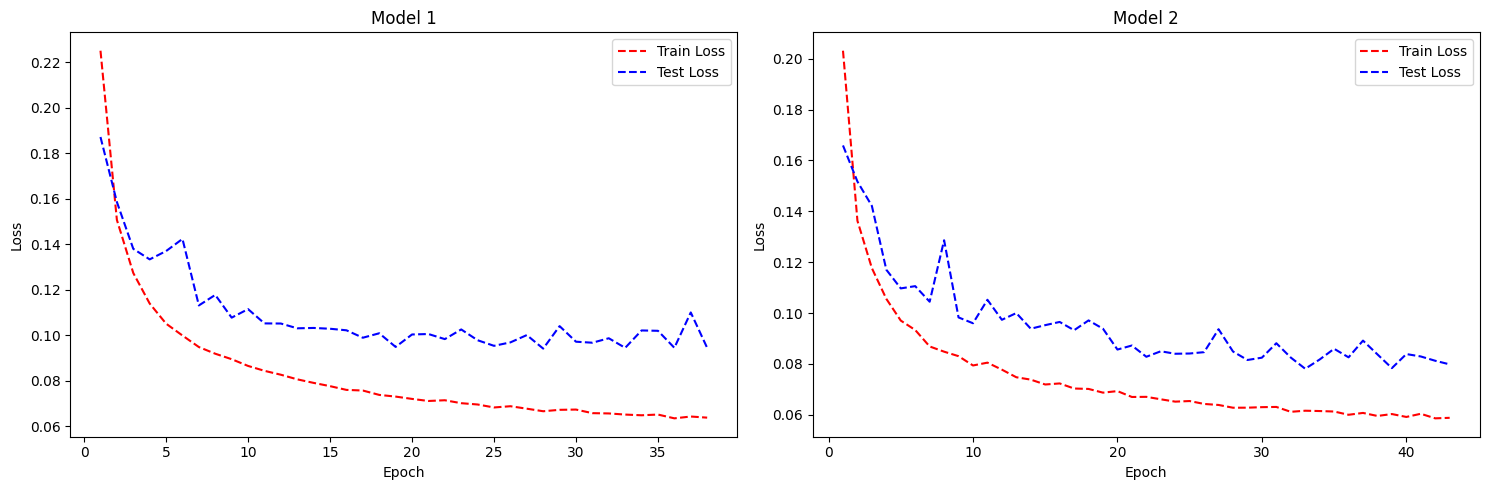

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(count1, train_loss1, 'r--', label='Train Loss')
axs[0].plot(count1, test_loss1, 'b--', label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Model 1')
axs[0].legend()

axs[1].plot(count2, train_loss2, 'r--', label='Train Loss')
axs[1].plot(count2, test_loss2, 'b--', label='Test Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Model 2')
axs[1].legend()

plt.tight_layout()
plt.show()

# Comparison of Results

In [69]:
results_df

,activation,loss,optimizer,layer_number,neuron_number,score
0,relu,huber_loss,adam,3,32,0.061224
1,relu,huber_loss,rmsprop,2,32,0.095443
2,relu,custom_loss1,rmsprop,2,32,0.094182
3,relu,custom_loss2,rmsprop,2,32,0.088350
